# Описание проекта

**Описание**

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

**Цель**

Предсказать вероятность покупки в течение 90 дней

**Задачи**

● Изучить данные

● Разработать полезные признаки

● Создать модель для классификации пользователей

● Улучшить модель и максимизировать метрику roc_auc

● Выполнить тестирование

# Импорты и загрузка данных

In [1]:
#!pip install shap -q

In [2]:
# загружаем требуемые библиотеки
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import phik
import shap
from phik.report import plot_correlation_matrix
import seaborn as sns
pd.set_option('display.max_columns', None)

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# загружаем нужные модели
from catboost import CatBoostClassifier, Pool
from sklearn.utils.class_weight import compute_class_weight
import os

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

RANDOM_STATE = 42
TEST_SIZE = 0.2

Загрузим файлы с данными:

apparel-purchases
Данные о покупках клиентов по дням и по товарам

apparel-messages
Рассылки, которые были отправлены клиентам из таблицы покупок

apparel-target_binary
факты покупок клиентов в целевом периоде

full_campaign_daily_event
Агрегация общей базы рассылок по дням и типам событий

full_campaign_daily_event_channel
Агрегация по дням с учетом событий и каналов рассылки


## purchases

In [3]:
purchases = pd.read_csv('datasets/apparel-purchases.csv', sep=',', decimal='.', parse_dates=['date'])

In [4]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


In [5]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [6]:
purchases.query('client_id == 1515915625468169594')['message_id'].value_counts()

message_id
1515915625468169594-14161-655db26e4d76f    4
1515915625468169594-4301-627b661e9736d     2
1515915625468169594-13392-649554cd9b5ee    2
1515915625468169594-7180-634d2f82d8799     1
Name: count, dtype: int64

In [7]:
purchases.nunique()

client_id       49849
quantity           16
price            3642
category_ids      933
date              642
message_id      50204
dtype: int64

In [8]:
purchases['date'].max()

Timestamp('2024-02-16 00:00:00')

Добавим признак "дальность последней покупки": дата выгрузки - дата посл. покупки

дата выгрузки = макс. дата по всем покупкам + 1

In [9]:
purchases['sale_distance'] = (pd.to_datetime('2024-02-16 00:00:00') - purchases['date']).dt.days

In [10]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id,sale_distance
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,641
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,641
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,641
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,641
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,641


Сгруппируем датасет по client_id

In [11]:
purchases_grouped = (purchases
                     .pivot_table(
                         index='client_id', 
                         values=['quantity', 'price', 'sale_distance', 'date'], 
                         aggfunc={'quantity':['sum','count'], 
                                  'price':['sum','mean'],
                                  'sale_distance':'min',
                                  'date':['min','max']
                                 })
                      .rename_axis(None, axis=0)
                    )

In [12]:
purchases_grouped.columns = ['last_date',
                             'first_date',
                             'mean_money', 
                             'total_money', 
                             'total_sales', 
                             'total_units', 
                             'min_sale_distance'
]

In [13]:
purchases_grouped['sale_period'] = (purchases_grouped['last_date'] - purchases_grouped['first_date']).dt.days

In [14]:
purchases_grouped.head()

,last_date,first_date,mean_money,total_money,total_sales,total_units,min_sale_distance,sale_period
1515915625468060902,2022-05-27,2022-05-27,999.000000,6993.0,7,7,630,0
1515915625468061003,2023-01-04,2023-01-04,2319.285714,16235.0,7,7,408,0
1515915625468061099,2022-05-17,2022-05-17,299.000000,299.0,1,1,640,0
1515915625468061100,2024-02-10,2024-02-10,1049.000000,2098.0,2,2,6,0
1515915625468061170,2023-06-17,2023-03-26,1768.473684,33601.0,19,19,244,83


In [15]:
purchases_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   last_date          49849 non-null  datetime64[ns]
 1   first_date         49849 non-null  datetime64[ns]
 2   mean_money         49849 non-null  float64       
 3   total_money        49849 non-null  float64       
 4   total_sales        49849 non-null  int64         
 5   total_units        49849 non-null  int64         
 6   min_sale_distance  49849 non-null  int64         
 7   sale_period        49849 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(4)
memory usage: 3.4 MB


## messages

In [16]:
messages = pd.read_csv('datasets/apparel-messages.csv', sep=',', decimal='.', parse_dates=['date'])

In [17]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 680.4+ MB


In [18]:
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [19]:
messages.nunique()

bulk_campaign_id       2709
client_id             53329
message_id          9061667
event                    11
channel                   2
date                    638
created_at          4103539
dtype: int64

In [20]:
messages.query('client_id == 1515915625468169594')['message_id'].value_counts()

message_id
1515915625468169594-14161-655db26e4d76f    7
1515915625468169594-6316-63201cb38c036     6
1515915625468169594-13392-649554cd9b5ee    5
1515915625468169594-10043-63e60cedcce41    5
1515915625468169594-7180-634d2f82d8799     5
                                          ..
1515915625468169594-7659-6368e568405ac     2
1515915625468169594-7475-635f80b6bb8a1     2
1515915625468169594-14624-65c5e2327aa23    2
1515915625468169594-14468-65a0ffaf6eada    1
1515915625468169594-14508-65aa65a4812ce    1
Name: count, Length: 114, dtype: int64

In [21]:
messages.query('client_id == 1515915625468061170')['message_id'].nunique()

243

In [22]:
purchases.query('client_id not in @messages.client_id')['client_id'].nunique()

7867

In [23]:
messages.client_id.nunique()

53329

Добавим признак "дальность последнего сообщения": дата выгрузки - дата посл. сообщения

дата выгрузки = макс. дата по всем покупкам + 1

In [24]:
messages['msg_distance'] = (pd.to_datetime('2024-02-16 00:00:00') - messages['date']).dt.days

Сгруппируем датасет по client_id

In [25]:
messages_grouped = (messages
                    .pivot_table(
                        index='client_id', 
                        values=['message_id', 'msg_distance', 'bulk_campaign_id'], 
                        aggfunc={'message_id':['count', lambda x: len(x.unique())],
                                 'msg_distance':'min',
                                 'bulk_campaign_id':lambda x: len(x.unique())
                                })
                    .rename_axis(None, axis=0)
                   )

In [26]:
messages_grouped.columns = ['num_bulk_campaigns',
                            'num_unique_messages',
                            'num_messages',
                            'min_msg_distance'
]

In [27]:
messages_grouped.head()

,num_bulk_campaigns,num_unique_messages,num_messages,min_msg_distance
1515915625468060902,127,127,177,28
1515915625468061003,154,154,166,3
1515915625468061099,215,215,276,3
1515915625468061100,265,268,434,1
1515915625468061170,240,243,293,1


## apparel-target_binary

In [28]:
target = pd.read_csv('datasets/apparel-target_binary.csv', sep=',', decimal='.')

In [29]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [30]:
target.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [31]:
target.target.value_counts()

target
0    48888
1      961
Name: count, dtype: int64

In [32]:
target.nunique()

client_id    49849
target           2
dtype: int64

In [33]:
target.query('client_id not in @purchases.client_id')['client_id'].nunique()

0

In [34]:
target.query('client_id not in @messages.client_id')['client_id'].nunique()

7867

In [35]:
purchases.query('client_id not in @target.client_id')['client_id'].nunique()

0

## full_campaign_daily_event

In [36]:
event = pd.read_csv('datasets/full_campaign_daily_event.csv', sep=',', decimal='.', parse_dates=['date'])

In [37]:
event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 131072 non-null  datetime64[ns]
 1   bulk_campaign_id     131072 non-null  int64         
 2   count_click          131072 non-null  int64         
 3   count_complain       131072 non-null  int64         
 4   count_hard_bounce    131072 non-null  int64         
 5   count_open           131072 non-null  int64         
 6   count_purchase       131072 non-null  int64         
 7   count_send           131072 non-null  int64         
 8   count_soft_bounce    131072 non-null  int64         
 9   count_subscribe      131072 non-null  int64         
 10  count_unsubscribe    131072 non-null  int64         
 11  nunique_click        131072 non-null  int64         
 12  nunique_complain     131072 non-null  int64         
 13  nunique_hard_b

In [38]:
event.head()

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,nunique_click,nunique_complain,nunique_hard_bounce,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


## full_campaign_daily_event_channel

In [39]:
event_channel = pd.read_csv('datasets/full_campaign_daily_event_channel.csv', sep=',', decimal='.', parse_dates=['date'])

In [40]:
event_channel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   date                             131072 non-null  datetime64[ns]
 1   bulk_campaign_id                 131072 non-null  int64         
 2   count_click_email                131072 non-null  int64         
 3   count_click_mobile_push          131072 non-null  int64         
 4   count_open_email                 131072 non-null  int64         
 5   count_open_mobile_push           131072 non-null  int64         
 6   count_purchase_email             131072 non-null  int64         
 7   count_purchase_mobile_push       131072 non-null  int64         
 8   count_soft_bounce_email          131072 non-null  int64         
 9   count_subscribe_email            131072 non-null  int64         
 10  count_unsubscribe_email          131072 non-

In [41]:
event_channel.head()

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,nunique_click_email,nunique_click_mobile_push,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_soft_bounce_email,nunique_subscribe_email,nunique_unsubscribe_email,count_hard_bounce_mobile_push,count_send_mobile_push,nunique_hard_bounce_mobile_push,nunique_send_mobile_push,count_hard_bounce_email,count_hbq_spam_email,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Предобработка данных

In [42]:
messages_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53329 entries, 1515915625468060902 to 1515915626010288690
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   num_bulk_campaigns   53329 non-null  int64
 1   num_unique_messages  53329 non-null  int64
 2   num_messages         53329 non-null  int64
 3   min_msg_distance     53329 non-null  int64
dtypes: int64(4)
memory usage: 2.0 MB


# Исследовательский анализ данных

## Формирование общего датасета

Объединим датасеты target, покупки и сообщения

In [43]:
df = target.join(purchases_grouped, on='client_id', how='left') 

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   client_id          49849 non-null  int64         
 1   target             49849 non-null  int64         
 2   last_date          49849 non-null  datetime64[ns]
 3   first_date         49849 non-null  datetime64[ns]
 4   mean_money         49849 non-null  float64       
 5   total_money        49849 non-null  float64       
 6   total_sales        49849 non-null  int64         
 7   total_units        49849 non-null  int64         
 8   min_sale_distance  49849 non-null  int64         
 9   sale_period        49849 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(6)
memory usage: 3.8 MB


In [45]:
df.head()

,client_id,target,last_date,first_date,mean_money,total_money,total_sales,total_units,min_sale_distance,sale_period
0,1515915625468060902,0,2022-05-27,2022-05-27,999.000000,6993.0,7,7,630,0
1,1515915625468061003,1,2023-01-04,2023-01-04,2319.285714,16235.0,7,7,408,0
2,1515915625468061099,0,2022-05-17,2022-05-17,299.000000,299.0,1,1,640,0
3,1515915625468061100,0,2024-02-10,2024-02-10,1049.000000,2098.0,2,2,6,0
4,1515915625468061170,0,2023-06-17,2023-03-26,1768.473684,33601.0,19,19,244,83


In [46]:
df_3 = df.join(messages_grouped, on='client_id', how='left') 

In [47]:
df_3.head()

,client_id,target,last_date,first_date,mean_money,total_money,total_sales,total_units,min_sale_distance,sale_period,num_bulk_campaigns,num_unique_messages,num_messages,min_msg_distance
0,1515915625468060902,0,2022-05-27,2022-05-27,999.000000,6993.0,7,7,630,0,127.0,127.0,177.0,28.0
1,1515915625468061003,1,2023-01-04,2023-01-04,2319.285714,16235.0,7,7,408,0,154.0,154.0,166.0,3.0
2,1515915625468061099,0,2022-05-17,2022-05-17,299.000000,299.0,1,1,640,0,215.0,215.0,276.0,3.0
3,1515915625468061100,0,2024-02-10,2024-02-10,1049.000000,2098.0,2,2,6,0,265.0,268.0,434.0,1.0
4,1515915625468061170,0,2023-06-17,2023-03-26,1768.473684,33601.0,19,19,244,83,240.0,243.0,293.0,1.0


In [48]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   client_id            49849 non-null  int64         
 1   target               49849 non-null  int64         
 2   last_date            49849 non-null  datetime64[ns]
 3   first_date           49849 non-null  datetime64[ns]
 4   mean_money           49849 non-null  float64       
 5   total_money          49849 non-null  float64       
 6   total_sales          49849 non-null  int64         
 7   total_units          49849 non-null  int64         
 8   min_sale_distance    49849 non-null  int64         
 9   sale_period          49849 non-null  int64         
 10  num_bulk_campaigns   41982 non-null  float64       
 11  num_unique_messages  41982 non-null  float64       
 12  num_messages         41982 non-null  float64       
 13  min_msg_distance     41982 non-

Заполним пропуски нулями там, где это приемлемо:

In [49]:
df_3['num_bulk_campaigns'].fillna(0, inplace=True)
df_3['num_unique_messages'].fillna(0, inplace=True)
df_3['num_messages'].fillna(0, inplace=True)

## Количественные признаки

In [50]:
df_3.describe().T

,count,mean,min,25%,50%,75%,max,std
client_id,49849.0,1515915625598796032.0,1515915625468060928.0,1515915625489972736.0,1515915625556614912.0,1515915625633408768.0,1515915626010443520.0,148794665.085077
target,49849.0,0.019278,0.0,0.0,0.0,0.0,1.0,0.137503
last_date,49849,2023-02-19 01:38:30.329193984,2022-05-16 00:00:00,2022-08-23 00:00:00,2023-03-05 00:00:00,2023-06-28 00:00:00,2024-02-16 00:00:00,NaN
first_date,49849,2023-01-28 22:28:08.314710272,2022-05-16 00:00:00,2022-08-03 00:00:00,2022-12-26 00:00:00,2023-06-14 00:00:00,2024-02-16 00:00:00,NaN
mean_money,49849.0,1483.415229,1.0,699.0,1249.0,1999.0,53499.0,1388.178005
total_money,49849.0,4840.520632,1.0,1499.0,2929.0,5677.0,540408.0,7312.865458
total_sales,49849.0,4.05641,1.0,1.0,2.0,5.0,346.0,5.521669
total_units,49849.0,4.08271,1.0,1.0,2.0,5.0,355.0,5.562927
min_sale_distance,49849.0,361.931593,0.0,233.0,348.0,542.0,641.0,185.301691
sale_period,49849.0,21.132199,0.0,0.0,0.0,0.0,636.0,76.842637


In [51]:
features_list = [
    'target',
    'mean_money', 
    'total_money', 
    'total_sales', 
    'total_units',
    'min_sale_distance',
    'sale_period',
    'num_bulk_campaigns',
    'num_unique_messages',
    'num_messages',
    'min_msg_distance',
]

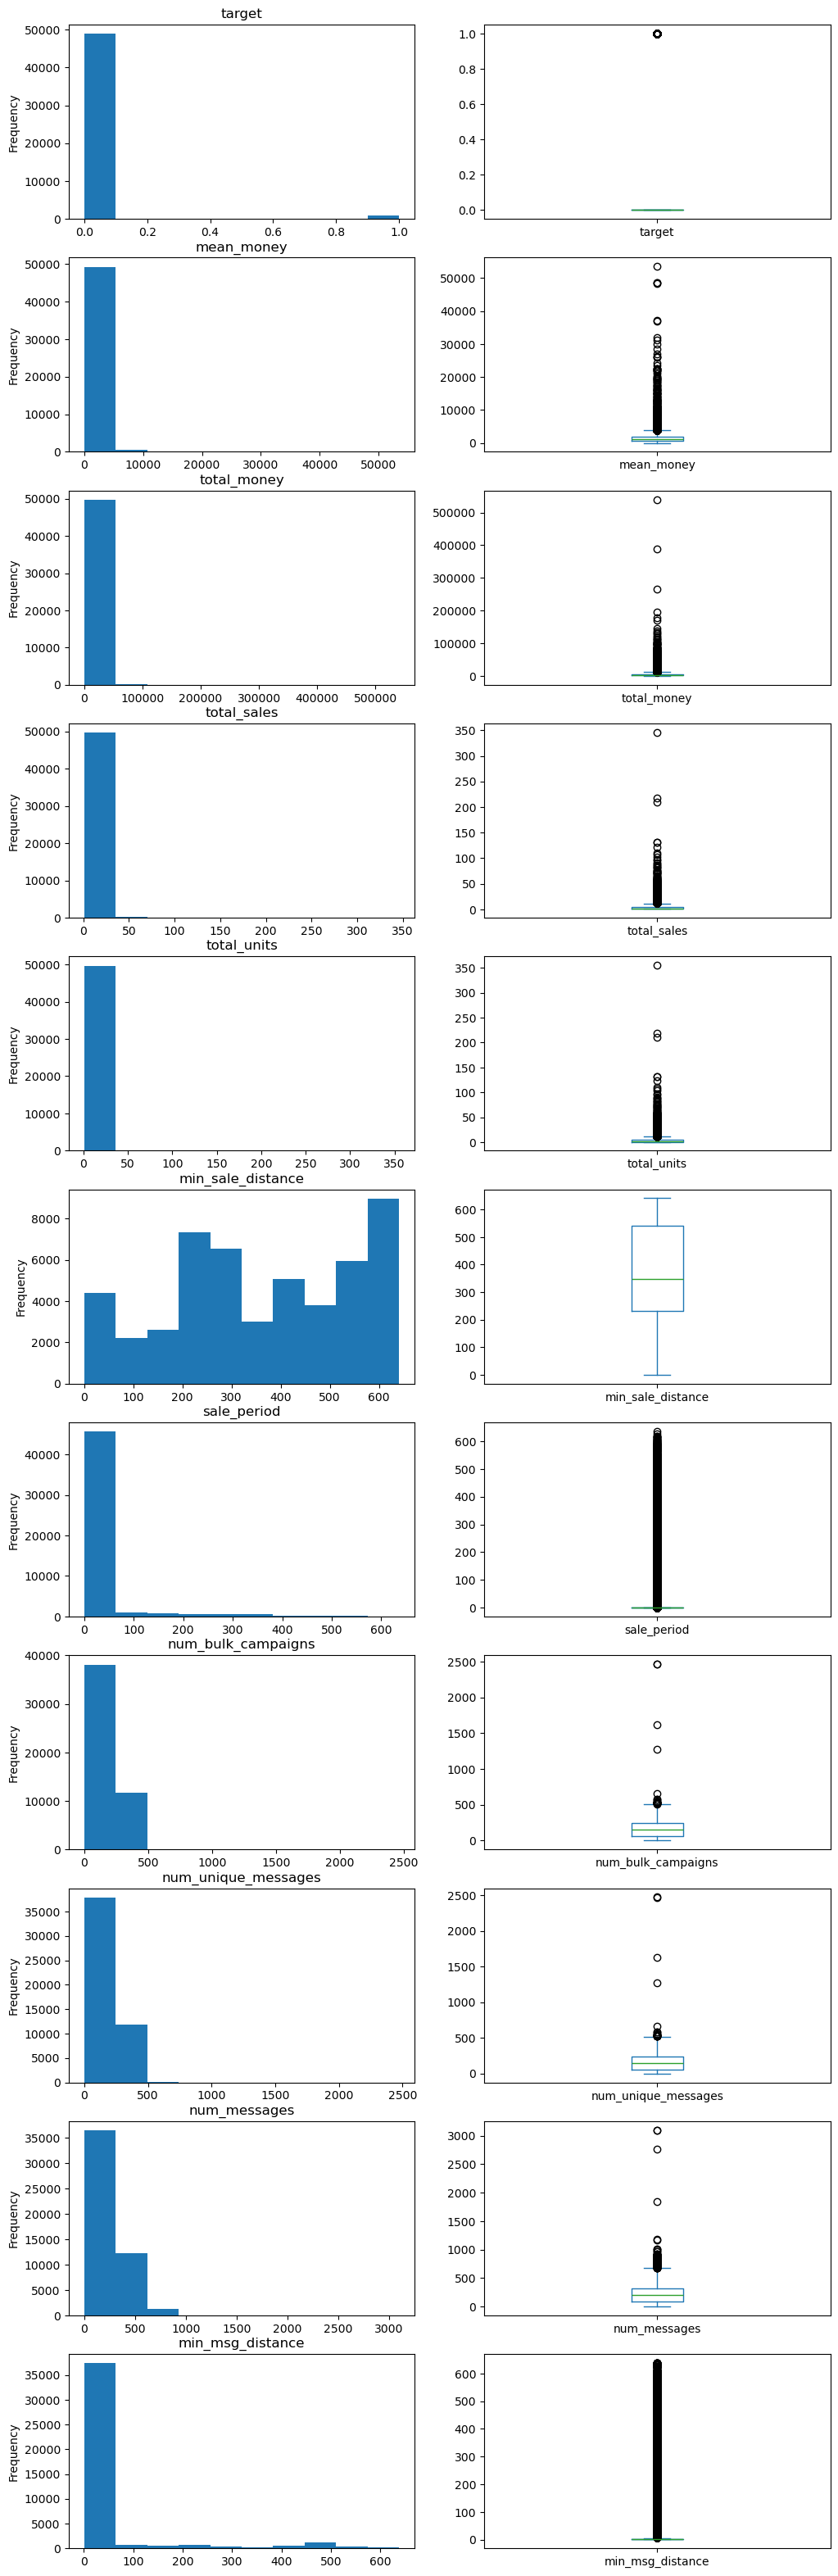

In [52]:
fig, ax = plt.subplots(nrows=11, ncols=2, figsize=(12, 40))
ax = ax.flatten()
j = 0
for i in features_list:
    df_3[i].plot(kind='hist', ax=ax[j], rot=0)
    ax[j].set_title(i);
    df_3[i].plot(kind='box', ax=ax[j+1], rot=0)
    j = j + 2

## Корреляция признаков между собой

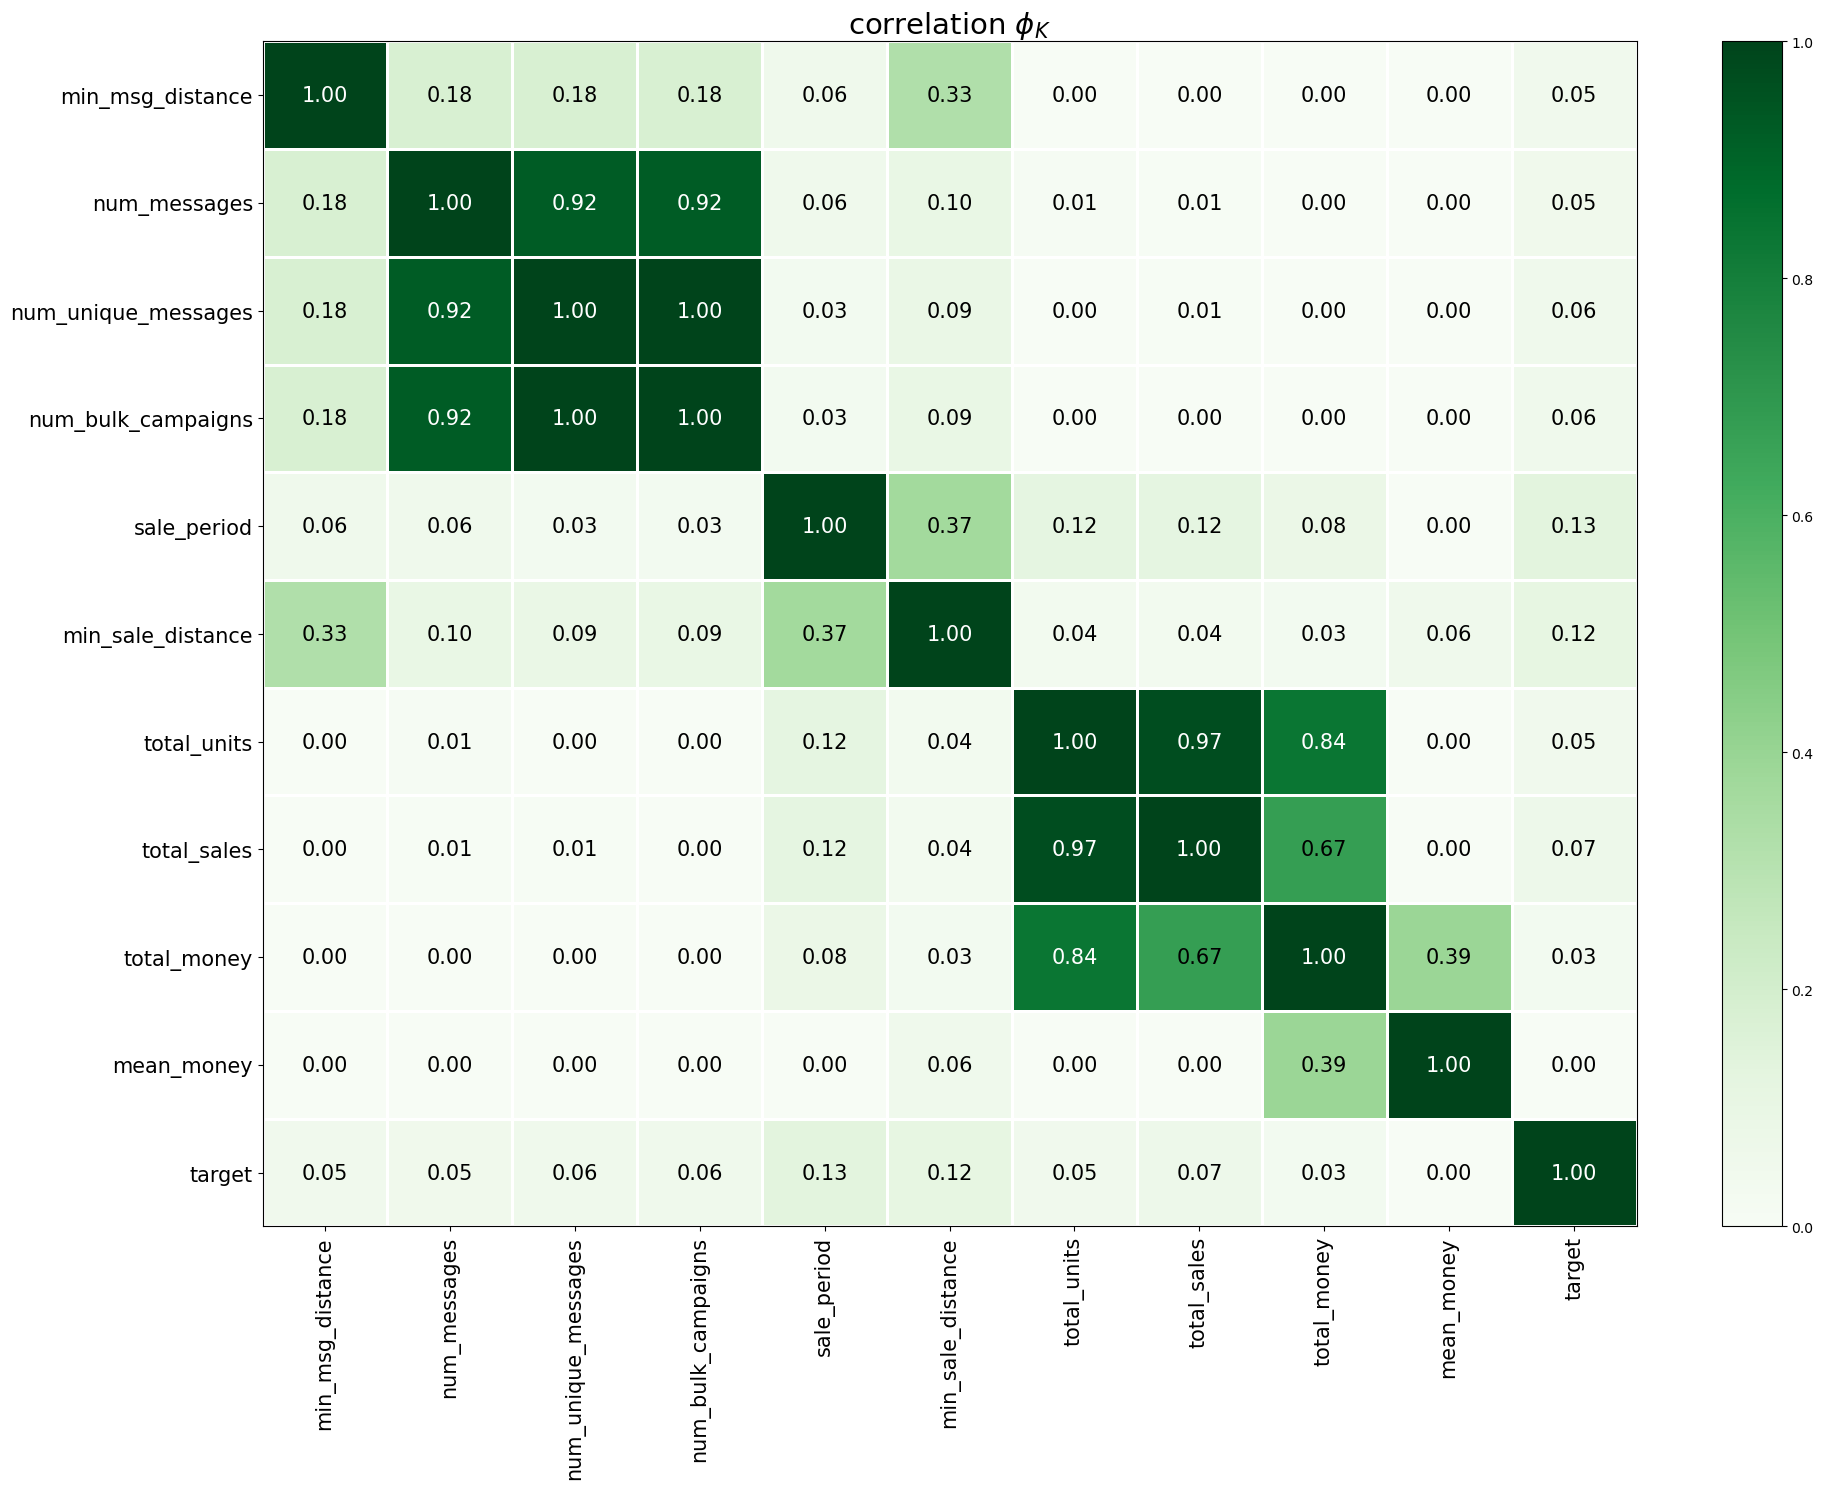

In [53]:
phik_overview = df_3[features_list].phik_matrix(interval_cols=features_list)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Вывод: имеется полная коллинеарность между признаками 'num_bulk_campaigns' и 'num_unique_messages', а также высокая коллинеарность между total_sales и total_units, также между num_messages и num_bulk_campaigns и между num_messages и num_unique_messages


# Подготовка данных

## Сформируем выборки

In [54]:
#X_train = df_3.drop(columns=['target', 'client_id'])
#y_train = df_3['target']

Отделим тестовую выборку

In [55]:
X = df_3.drop(columns=[
    'target', 
    'client_id',
    'mean_money',
    'first_date',
    'last_date',
    'min_msg_distance',
    'num_bulk_campaigns',
    'num_unique_messages'
])
y = df_3['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

Создадим тренировочную и валидационную выборки

In [56]:
X = X_train
y = y_train
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

In [57]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31903 entries, 48495 to 31756
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total_money        31903 non-null  float64
 1   total_sales        31903 non-null  int64  
 2   total_units        31903 non-null  int64  
 3   min_sale_distance  31903 non-null  int64  
 4   sale_period        31903 non-null  int64  
 5   num_messages       31903 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 1.7 MB


## Создадим списки с названиями признаков

In [58]:
num_columns = [
#    'mean_money',         -- признак исключен, поскольку снижает метрику
    'total_money', 
    'total_sales', 
    'total_units',
    'min_sale_distance',
    'sale_period',
    'num_messages',
#    'min_msg_distance',   -- признак исключен, поскольку снижает метрику
#    'num_bulk_campaigns', -- признак исключен, поскольку снижает метрику
#    'num_unique_messages' -- признак исключен, поскольку снижает метрику
]

## Подготовим пайплайны

Учтем дисбаланс целевого признака

In [59]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [60]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', CatBoostClassifier(verbose=0))
])

param_grid = [
    
    # словарь для модели CatBoostClassifier()
    {
        'models': [CatBoostClassifier(
            class_weights = class_weights, 
            random_state = RANDOM_STATE,
            verbose = 0
        )],
        'models__iterations': [100],
        'models__depth': [4, 6, 8],
        'models__learning_rate': [0.01, 0.1, 0.2],
        'models__od_type': ['IncToDec', 'Iter'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },   
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 25),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(4, 6),
        'models__max_features': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели LogisticRegression()
#    {
#        'models': [LogisticRegression(
#            random_state=RANDOM_STATE, 
#            solver='liblinear', 
#            penalty='l1'
#        )],
#        'models__C': range(1, 7),
#        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
#    },

    # словарь для модели SVC()
    # Модель дает низкие значения метрики (0,51) и работает ОЧЕНЬ долго
    # поэтому в итоговом расчете я ее закомментировал
#    {
#        'models': [SVC(
#            probability=True, 
#            random_state=RANDOM_STATE)],
#        'models__gamma': [0.1, 1, 10, 100],
#        'models__C': [0.1, 1, 10, 100],
#        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
#    },

]

# Обучим модели

## Обучим модели и подберем гиперпараметры

In [61]:
# Используем метрику  при подборе гиперпараметров и оценке качества моделей. 
randomizedsearch = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [62]:
randomizedsearch.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomizedsearch.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации по тренировочной выборке:', randomizedsearch.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['total_money', 'total_sales',
                                                   'total_units',
                                                   'min_sale_distance',
                                                   'sale_period',
                                                   'num_messages'])])),
                ('models',
                 <catboost.core.CatBoostClassifier object at 0x00000210C0D178C0>)])
Метрика лучшей модели на кросс-валидации по тренировочной выборке: 0.7135877780904989


## Проверим модель на валидационной выборке

In [63]:
print(f'Метрика ROC-AUC лучшей модели на валидационной выборке: \
{roc_auc_score(y_val, randomizedsearch.predict_proba(X_val)[:, 1])}')

Метрика ROC-AUC лучшей модели на валидационной выборке: 0.7607960659884397


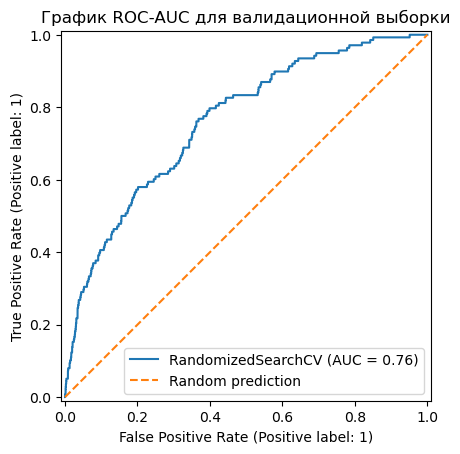

In [64]:
# ROC-кривая для валидационной выборки
RocCurveDisplay.from_estimator(randomizedsearch, X_val, y_val)
plt.plot([0,1], [0,1], linestyle='dashed', label='Random prediction')
plt.title("График ROC-AUC для валидационной выборки")
plt.legend()
plt.show()

## Проверим модель на тестовой выборке

In [65]:
print(f'Метрика ROC-AUC лучшей модели на тестовой выборке: \
{roc_auc_score(y_test, randomizedsearch.predict_proba(X_test)[:, 1])}')

Метрика ROC-AUC лучшей модели на тестовой выборке: 0.722066864730064


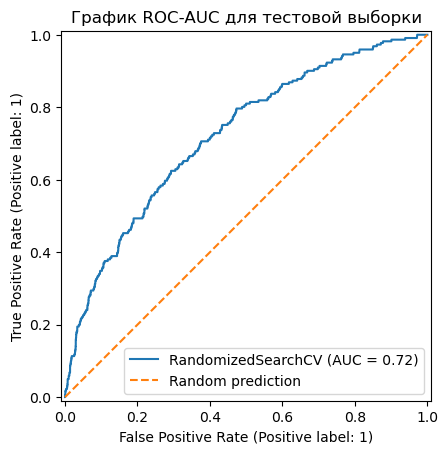

In [66]:
# ROC-кривая для тестовой выборки
RocCurveDisplay.from_estimator(randomizedsearch, X_test, y_test)
plt.plot([0,1], [0,1], linestyle='dashed', label='Random prediction')
plt.title("График ROC-AUC для тестовой выборки")
plt.legend()
plt.show()

Вопрос ревьюеру:
прошу подсказать, можно ли, не выполняя повторно расчетов,
построить график ROC-AUC для других моделей, которые участвовали в расчете.
Если можно, прошу уточнить, как это можно сделать. Спасибо.

In [67]:
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(randomizedsearch.cv_results_)
print(result[['rank_test_score', 'param_models', 'mean_test_score','params']].
      sort_values('rank_test_score')) 

   rank_test_score  \
0                1   
5                2   
1                3   
7                4   
3                5   
2                6   
9                6   
8                8   
6                9   
4               10   

                                                      param_models  \
0  <catboost.core.CatBoostClassifier object at 0x000002108375D5E0>   
5  <catboost.core.CatBoostClassifier object at 0x000002108375D5E0>   
1  <catboost.core.CatBoostClassifier object at 0x000002108375D5E0>   
7                          DecisionTreeClassifier(random_state=42)   
3  <catboost.core.CatBoostClassifier object at 0x000002108375D5E0>   
2                          DecisionTreeClassifier(random_state=42)   
9                          DecisionTreeClassifier(random_state=42)   
8                                           KNeighborsClassifier()   
6                                           KNeighborsClassifier()   
4                                           KNeighborsCla

# Оценим влияние входных признаков на целевой

In [68]:
model = CatBoostClassifier(
    class_weights = class_weights, 
    random_state = 42,
    od_type = 'IncToDec', 
    learning_rate = 0.01, 
    iterations = 100, 
    depth = 6,
    verbose = 0
)

In [69]:
model.fit(X_train, y_train)

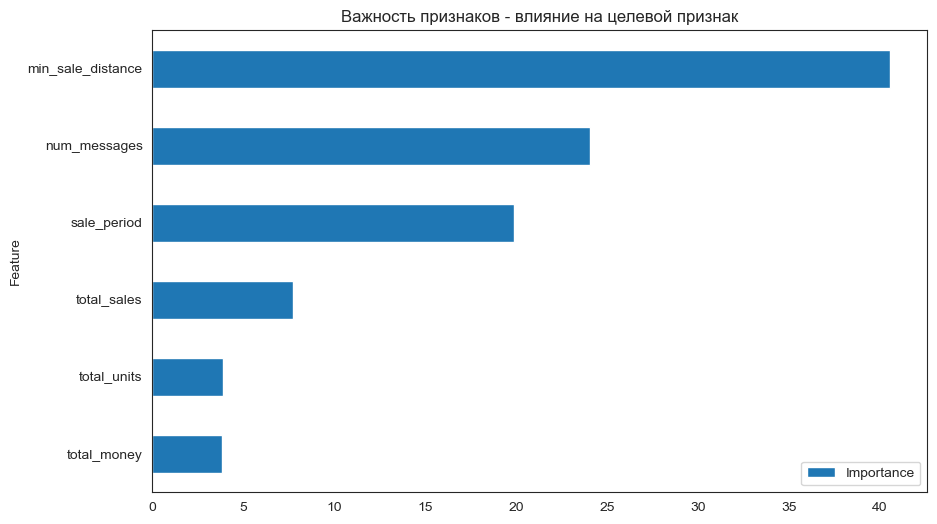

In [70]:
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6)) \
    .set_title("Важность признаков - влияние на целевой признак");

In [71]:
train_shap = shap.sample(X_train, 50, random_state=RANDOM_STATE)
explainer = shap.KernelExplainer(model.predict_proba, train_shap)
randomizedsearch.predict_proba(X_test)[:, 1]

test_shap = shap.sample(X_test, 50, random_state=RANDOM_STATE)
shap_values = explainer(test_shap)

  0%|          | 0/50 [00:00<?, ?it/s]

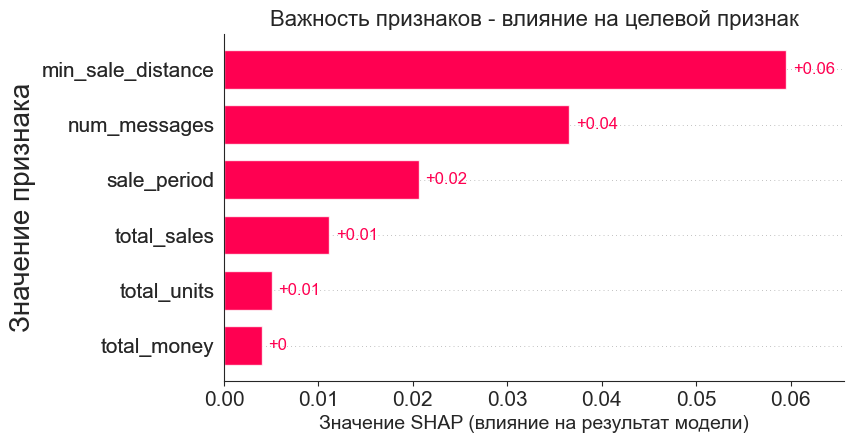

In [72]:
shap.plots.bar(shap_values[..., 1], show=False) 
#shap.summary_plot(shap_values, X_test, cmap=color_map, show=False)

# Get the current figure and axes objects. from @GarrettCGraham code
fig, ax = plt.gcf(), plt.gca()

# Modifying main plot parameters
ax.tick_params(labelsize=14)
ax.set_xlabel("Значение SHAP (влияние на результат модели)", fontsize=14)
ax.set_title('Важность признаков - влияние на целевой признак', fontsize=16)

# Get colorbar
cb_ax = fig.axes[0] 

# Modifying color bar parameters
cb_ax.tick_params(labelsize=15)
cb_ax.set_ylabel("Значение признака", fontsize=20)

plt.show()

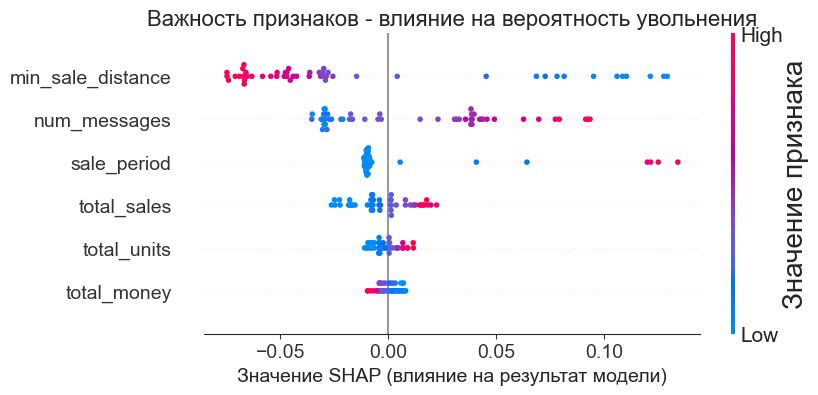

In [73]:
shap.plots.beeswarm(shap_values[..., 1], show=False) 
#shap.summary_plot(shap_values, X_test, cmap=color_map, show=False)

# Get the current figure and axes objects. from @GarrettCGraham code
fig, ax = plt.gcf(), plt.gca()

# Modifying main plot parameters
ax.tick_params(labelsize=14)
ax.set_xlabel("Значение SHAP (влияние на результат модели)", fontsize=14)
ax.set_title('Важность признаков - влияние на вероятность увольнения', fontsize=16)

# Get colorbar
cb_ax = fig.axes[1] 

# Modifying color bar parameters
cb_ax.tick_params(labelsize=15)
cb_ax.set_ylabel("Значение признака", fontsize=20)

plt.show()

Факторы, влияющие более всего на целевой признак, следующие:

1. Минимальное расстояние от текущего момента до последней покупки в прошлом.
2. Количество сообщений клиенту.
3. Величина периода, в течение которого клиент совершал покупки.
4. Общее количество покупок.
5. Общее количество купленных товаров.
6. Общее количество потраченных денег.

# Общий вывод

В ходе выполнения проекта получен требуемый результат:

● построена модель, позволяющая предсказать вероятность покупки.

При этом, были решены все поставленные задачи:

- Изучены данные

- Разработаны полезные признаки

- Создана модель для классификации пользователей

- Улучшена модель и максимизирована метрика roc_auc

- Выполнено тестирование

Дополнительно решены задачи:

- Оценено влияние входных признаков на целевой признак